In [200]:
import json
import math
from matplotlib import pyplot as plt 

INF = 9999


def get_keypoints(vidname,size):
    posepoints = []
    for i in range(size+1): # 0~num i를 1씩 증가시키면서 반복
        num = format(i,"012") # 0000000000000 문자열로 저장(12자리 0)
        jfilename = vidname +"_"+num +"_keypoints.json"
        with open('json/'+jfilename, 'r') as f:
            json_data = json.load(f)  # json파일 불러오기댐
            # 첫번째 사람만 본다. 2명일때 예외처리 나중에해야
            keypoint = {'x': 0, 'y': 0, 'c': 0}  # 마지막 c는 신뢰도..0.3이하면 신뢰하지 않는다
            posepoint = []

            if not json_data['people'] : #openpose의 output은 물체에 사람이 잡히지 않을경우 poeple배열을 비운다. 빈 리스트인지 확인하는 코드
                return posepoints

            for j in range(75):  # 관절개수가 25개(0~24)
                if j % 3 == 0:  # 0번째 자리
                    keypoint['x'] = json_data['people'][0]['pose_keypoints_2d'][j]
                elif j % 3 == 1:
                    keypoint['y'] = json_data['people'][0]['pose_keypoints_2d'][j]
                elif j % 3 == 2:
                    keypoint['c'] = json_data['people'][0]['pose_keypoints_2d'][j]
                    posepoint.append(keypoint.copy())  # 리스트는 깊은복사라서.. copy로
                    # print(keypoint)
        posepoints.append(posepoint.copy())
    return posepoints

def get_slope(x1,y1,x2,y2): #두 점의 좌표를 가지고 기울기를 구하는 함수 (이번 코드에는 사용하지 않았음 ㅎㅎ;)
    if x1 != x2: #분모가 0이되는 상황 방지
        radian = math.arctan((y2-y1)/(x2-x1))
    return radian

def get_distan(point1,point2): #두 점 사이의 거리를 구하는 공식
    a = point1.get('x') - point2.get('x')
    b = point2.get('y') - point2.get('y')
    return math.sqrt((a*a) + (b*b))

def get_angle(joint1,joint2,joint3): #두 몸체의 기울기를 가지고 관절의 각도를구하는 함수      locate ->  j1 ------ j2 ------- j3
    if(joint1.get('x')-joint2.get('x')) == 0:
        return 0
    if(joint3.get('x')-joint2.get('x')) == 0:
        return 0
    radi1 = math.atan2((joint1.get('y')-joint2.get('y')),(joint1.get('x')-joint2.get('x')))
    radi2 = math.atan2((joint3.get('y')-joint2.get('y')),(joint3.get('x')-joint2.get('x')))
    radian = radi1-radi2
    #print(radian)
    andgle = radian * (180 / math.pi)
    return abs(andgle) #각도를절댓값으로 변환 ^^

def cut_frame(posepoints) : #프레임을 어깨 각도를 통해 인식
    size = len(posepoints)
    flag = [0,0,0,  #[0. 어드래스, 1테이크어웨이,2백스윙
            0,0,0]  # 3탑,4 다운스윙,5 임팩트]

    left_wrist = get_y_wrist(posepoints,'left')
    right_wrist = get_y_wrist(posepoints, 'right')
    
    
    where_top = left_wrist.index(min(left_wrist)) #손목의 높이가 최대가 되는 곳을 리턴 (y축이 작을 수록 상단에 위치)
    print(where_top)
    where_top = right_wrist.index(min(right_wrist))  # 손목의 높이가 최대가 되는 곳을 리턴
    print(where_top)

    for i in range(size) :
        posepoint = posepoints[i] #i번째 프레임의 몸체 좌표를 저장
        if (is_adress(posepoint))  and (flag[1] ==0) :
            flag[0] = 1
            #print("어드래스!")
        if (flag[0] == 1) and (is_takeAway(posepoint)) and flag[2] == 0:
            flag[2] = 1
            #print("테이크어웨이")

        #angle_left_houlder = get_angle(posepoints[i][1], posepoints[i][2], posepoints[i][3])
        #angle_right_shoulder = get_angle(posepoints[i][1], posepoints[i][5], posepoints[i][6])
        #if(angle_right_shoulder <= 50) or (angle_left_shoulder <= 50):
         #   print("어드래스 시작")
        #else :
         #   print("?")

def get_y_wrist(posepoints,lr) : 
    #손목 위치의 함수를 반환,프레임배열과, 왼오 옵
    y_point_arr = []
    if (lr == "left"): #왼
        for i in range(len(posepoints)):
            lwrist = posepoints[i][4].get('y')
            if(lwrist == 0): #이상치에서 최소 값을 봐야하므로 inf로 대체
                y_point_arr.append(INF)
            elif (posepoints[i][4].get('c') < 0.2):
                y_point_arr.append(INF)
            else:y_point_arr.append(lwrist)
            
    elif (lr == "right"): #오른손
        for i in range(len(posepoints)):
            rwrist = posepoints[i][7].get('y')
            if(rwrist == 0): #이상치에서 최소 값을 봐야하므로 inf로 대체
                y_point_arr.append(INF)
            elif (posepoints[i][4].get('c') < 0.2):
                y_point_arr.append(INF)
            else:y_point_arr.append(rwrist)            
    return y_point_arr      

def get_x_wrist(posepoints,lr) : 
    #손목 위치의 함수를 반환,프레임배열과, 왼오 옵
    y_point_arr = []
    if (lr == "left"): #왼
        for i in range(len(posepoints)):
            lwrist = posepoints[i][4].get('x')
            if(lwrist == 0): #이상치에서 최소 값을 봐야하므로 inf로 대체
                y_point_arr.append(INF)
            elif (posepoints[i][4].get('c') < 0.2):
                y_point_arr.append(INF)
            else:y_point_arr.append(lwrist)
            
    elif (lr == "right"): #오른손
        for i in range(len(posepoints)):
            rwrist = posepoints[i][7].get('x')
            if(rwrist == 0): #이상치에서 최소 값을 봐야하므로 inf로 대체
                y_point_arr.append(INF)
            elif (posepoints[i][4].get('c') < 0.2):
                y_point_arr.append(INF)
            else:y_point_arr.append(rwrist)            
    return y_point_arr   
            
def is_adress(posepoint) : #손과 어깨의 연결이 예각삼각형이여야한다
    left_hand = posepoint[4]
    right_hand = posepoint[7]
    head_size = get_distan(posepoint[17], posepoint[18])
    hand_dis = get_distan(posepoint[4], posepoint[7])
    left_elbow_angel = get_angle(posepoint[2], posepoint[3],posepoint[4])
    right_elbow_angle = get_angle(posepoint[5], posepoint[6],posepoint[7])

    if head_size >= hand_dis : #머리 크기보다 손목사이의 거리가 좁으면 모아져 있다고 판단
        #print("손이 모아져 있습니다.")
        if (left_elbow_angel >= 160) and (right_elbow_angle >= 160):
            #print("팔꿈치가 펴져있습니다.")
            #좌 우 팔꿈치가 어느정도 펴져 있어야 한다.
            return True

def is_takeAway(posepoint) :
    head_size = get_distan(posepoint[17], posepoint[18])
    hand_dis = get_distan(posepoint[4], posepoint[7])

    if  head_size >= hand_dis : #머리 크기보다 손목사이의 거리가 좁으면 모아져 있다고 판단
        if posepoint[7].get('x') > posepoint[8].get('y'):
            #우측 팔목의 x축 배꼽아래보다 좌측에 있다.
            #print("손이 배꼽 아래에 있다.")
            return True

def is_top(l_wrist,r_wrist):
    x_values = []
    y_values = []
    for i in range(0,l_wrist.len):
        x_values.append(l_wrist[i])
        y_values.append(i)
    plt.plot(x_values,y_values)
    plt.show()
    return True

def get_head(posepoints):
    l_ear =posepoints[1][17]
    r_ear =posepoints[1][18]
    
    size = get_distan(l_ear,r_ear)
    print(size)
    return int(size)




posepoints = get_keypoints("gpps", 100)

    #joint num -------
    #1:어깨 중심    2 : 좌측어깨    3:좌측 팔꿈치    5 : 우측어꺠   6:우측팔꿈치 .. 
angle234 = get_angle(posepoints[0][2],posepoints[0][3],posepoints[0][4])
cut_frame(posepoints)
head_size=get_head(posepoints)

44
43
110.23700000000002


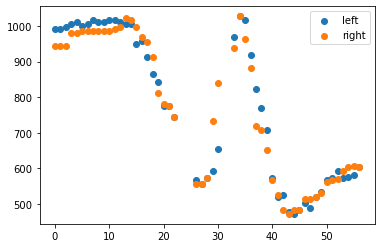

52
[990.511, 990.5, 995.756, 1006.07, 1011.29, 1001.05, 1006.21, 1016.56, 1011.43, 1011.46, 1016.5, 1016.44, 1011.39, 1006.26, 1006.16, 948.629, 958.947, 911.824, 864.73, 843.735, 775.631, 775.679, 744.217, 566.165, 555.702, 571.397, 592.397, 655.169, 969.447, 1027.18, 1016.73, 917.068, 822.804, 770.242, 707.594, 571.446, 519.072, 524.243, 477.296, 471.896, 482.181, 503.248, 487.549, 519.122, 534.842, 566.17, 571.455, 592.284, 571.484, 576.754, 581.911, 602.823]


In [201]:
size = len(posepoints)
flag = [0,0,0,0,0,0,0]  # 어,테,탑,다운,임펙,팔스,피니쉬

left_wrist = get_y_wrist(posepoints,'left')
right_wrist = get_y_wrist(posepoints, 'right')
    
    
where_top = left_wrist.index(min(left_wrist)) #손목의 높이가 최대가 되는 곳을 리턴 (y축이 작을 수록 상단에 위치)

where_top = right_wrist.index(min(right_wrist))  # 손목의 높이가 최대가 되는 곳을 리턴

lx_values = []
ly_values = []
rx_values = []
ry_values = []

for i in range(len(left_wrist)): #left wrist와 right wrist가 같다
    if(left_wrist[i] != INF): #inf값에는 포즈가 감지되지 않아 0값이 기록되어 있으므로 넘어간다. 
        ly_values.append(left_wrist[i])
        lx_values.append(i)
        
    if(right_wrist[i] != INF):
        ry_values.append(right_wrist[i])
        rx_values.append(i)
       
    
plt.scatter(lx_values,ly_values)
plt.scatter(rx_values,ry_values)


plt.legend(['left','right'])
plt.show()
print(len(lx_values))
print(ly_values)

[25, 13, 26, 0, 33, 0, 43]
[25, 13, 26, 29, 33, 38, 43]
-41.896999999999935


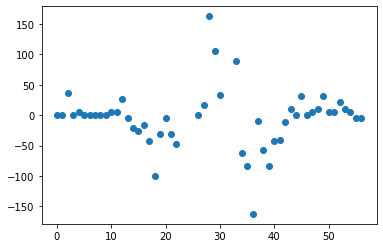

In [202]:
frame = 100
slopes=[]
idx = [25,0,0,0,0,0,43]#어,테,탑,다운,임펙,팔스,피니쉬

for i in range(0,len(rx_values)):
    if (len(rx_values)-1 == i): #마지막 점의 경우 변화량을 계산할 필요가 없음
        slopes.append(slope)
        break
    else :
        dx = rx_values[i+1] - rx_values[i] 
        dy = ry_values[i+1] - ry_values[i]
        slope = dy/dx
        if(slope <= -8 and idx[0]!=0 and idx[1]==0) : #테이크어웨이 검사
            dx_left = lx_values[i+1] - lx_values[i] 
            dy_left = ly_values[i+1] - ly_values[i] 
            slope_left = dy_left/dx_left
            #print(slope_left)
            if(slope_left<= -8):
                idx[1] = rx_values[i-1]
        
        if(idx[1]!=0 and idx[2]==0 and slope>0) :  #탑 검사
            dx_left = lx_values[i+1] - lx_values[i] 
            dy_left = ly_values[i+1] - ly_values[i] 
            slope_left = dy_left/dx_left
            if(slope_left>0):
                idx[2] = rx_values[i-1]
        if(idx[2]!=0 and idx[4]==0 and slope<0) : #임펙트 검사
            dx_left = lx_values[i+1] - lx_values[i] 
            dy_left = ly_values[i+1] - ly_values[i] 
            slope_left = dy_left/dx_left
            if(slope_left<0):
                idx[4] = rx_values[i-1]
        #if(idx[4]!=0 and idx[6]==0 and slope>0) : #피니쉬 검사
        #    dx_left = lx_values[i+1] - lx_values[i] 
        #    dy_left = ly_values[i+1] - ly_values[i] 
        #    slope_left = dy_left/dx_left
        #    print(slope_left)
        #    if(slope_left>0):
        #        idx[6] = rx_values[i-1]
        slopes.append(slope)
        
    

print(idx)
idx[3] = int((idx[4] + idx[2] )/2)
idx[5] = int((idx[6] + idx[4] )/2)
print(idx)

print(slopes[35])

plt.scatter(rx_values,slopes)

In [9]:
x = [x_values[k] for k in range(len(x_values))]
y = [y_values[m] for m in range(len(y_values))]
y_values[2]

943.308

1034.9947547256043
[-9.25585887e+00 -5.24282256e-03]


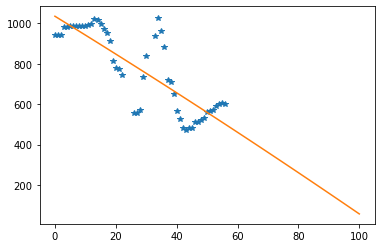

In [10]:
X2 = [[x[k], x[k]**2] for k in range(len(x_values))]

reg2 = linear_model.LinearRegression()
reg2.fit(X2,y)
print(reg2.intercept_)
print(reg2.coef_)

xp2 = [1*k for k in range(101)]
Xp2 = [[xp2[k], xp2[k]**2] for k in range(101)]
yp2 = reg2.predict(Xp2)

plt.plot(x, y, "*")
plt.plot(xp2, yp2)

889.698425713858
[ 4.74178324e+01 -5.12578881e+00  1.46677659e-01  3.15062213e-04
 -6.99586675e-05  7.42633837e-07]
0.7504227799461459


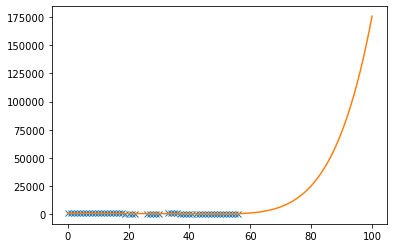

In [11]:
X9 = [[x[k]**n for n in range(1,7)] for k in range(len(x_values))]

# from sklearn import linear_model # already imported
reg9 = linear_model.LinearRegression()
reg9.fit(X9,y)
print(reg9.intercept_)
print(reg9.coef_)
print(reg9.score(X9,y))

xp9 = [1*k for k in range(101)]
Xp9 = [[xp9[k]**n for n in range(1,7)] for k in range(101)]
yp9 = reg9.predict(Xp9)

plt.plot(x, y, "x")
plt.plot(xp9, yp9)

In [13]:
X3 = [[x[k], x[k]**2, x[k]**3,x[k]**4] for k in range(len(x_values))]

# from sklearn import linear_model # already imported
reg3 = linear_model.LinearRegression()
reg3.fit(X3,y)
print(reg3.intercept_)
print(reg3.coef_)

xp3 = [1*k for k in range(101)]
Xp3 = [[xp[k], xp[k]**2, xp[k]**3,x[k]**4] for k in range(101)]
yp3 = reg3.predict(Xp3)

plt.plot(x, y, "x")
plt.plot(xp3, yp3)

969.6895497104249
[ 3.40298760e+00 -3.87800778e-01 -1.97871931e-03  1.00867244e-04]


IndexError: list index out of range

In [14]:
def get_x_wrist(posepoints,lr) : 
    #손목 위치의 함수를 반환,프레임배열과, 왼오 옵
    y_point_arr = []
    if (lr == "left"): #왼
        for i in range(len(posepoints)):
            lwrist = posepoints[i][4].get('x')
            if(lwrist == 0): #이상치에서 최소 값을 봐야하므로 inf로 대체
                y_point_arr.append(INF)
            elif (posepoints[i][4].get('c') < 0.2):
                y_point_arr.append(INF)
            else:y_point_arr.append(lwrist)
            
    elif (lr == "right"): #오른손
        for i in range(len(posepoints)):
            rwrist = posepoints[i][7].get('x')
            if(rwrist == 0): #이상치에서 최소 값을 봐야하므로 inf로 대체
                y_point_arr.append(INF)
            elif (posepoints[i][4].get('c') < 0.2):
                y_point_arr.append(INF)
            else:y_point_arr.append(rwrist)            
    return y_point_arr   

73


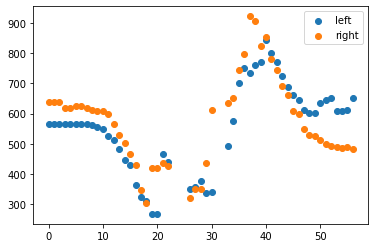

In [144]:
left_wrist = get_x_wrist(posepoints,'left')
right_wrist = get_x_wrist(posepoints, 'right')
    
    
where_top = left_wrist.index(min(left_wrist)) #손목의 높이가 최대가 되는 곳을 리턴 (y축이 작을 수록 상단에 위치)
where_top = right_wrist.index(min(right_wrist))  # 손목의 높이가 최대가 되는 곳을 리턴
print(len(x_values))

rx_values = []
ry_values = []
lx_values = []
ly_values = []

for i in range(len(left_wrist)):
    if(left_wrist[i] != INF): #inf값에는 포즈가 감지되지 않아 0값이 기록되어 있으므로 넘어간다. 
        ly_values.append(left_wrist[i])
        lx_values.append(i)
        
    if(right_wrist[i] != INF):
        ry_values.append(right_wrist[i])
        rx_values.append(i)
    
plt.scatter(lx_values,ly_values)
plt.scatter(rx_values,ry_values)
plt.legend(['left','right'])
plt.show()

0.06600000000003092
-25.86399999999992
[10, 0, 0, 0, 0, 0]
-20.83000000000004


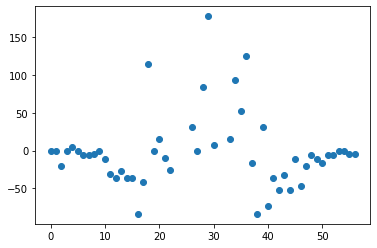

In [155]:
frame = 100
slopes=[]
idx = [0,0,0,0,0,0]
for i in range(0,len(rx_values)):
    if (len(rx_values)-1 == i): #마지막 점의 경우 변화량을 계산할 필요가 없음
        slopes.append(slope)
        break
    else : 
        dx = rx_values[i+1] - rx_values[i] 
        dy = ry_values[i+1] - ry_values[i]
        slope = dy/dx
        if(slope <= -8 and idx[0]==0) : #좌측으로 움직이면 x좌표의 변화량은 감소
            dx_left = lx_values[i+1] - lx_values[i] 
            dy_left = ly_values[i+1] - ly_values[i] 
            slope_left = dy_left/dx_left
            print(slope_left)
            if(slope_left<= -8):
                idx[0] = rx_values[i]
        slopes.append(slope)
        
    
print(idx)
print(slopes[2])

plt.scatter(rx_values,slopes)

527.6625382466739
[ 9.14285340e+01 -1.48485285e+01  7.51375098e-01 -1.49334325e-02
  1.02264137e-04]
0.7600261118238054


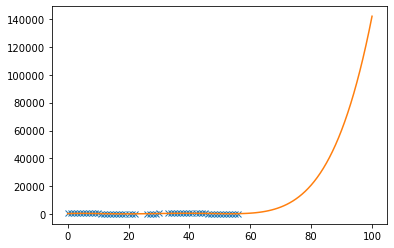

In [17]:
X9 = [[x[k]**n for n in range(1,6)] for k in range(len(x_values))]

# from sklearn import linear_model # already imported
reg9 = linear_model.LinearRegression()
reg9.fit(X9,y)
print(reg9.intercept_)
print(reg9.coef_)
print(reg9.score(X9,y))

xp9 = [1*k for k in range(101)]
Xp9 = [[xp9[k]**n for n in range(1,6)] for k in range(101)]
yp9 = reg9.predict(Xp9)

plt.plot(x, y, "x")
plt.plot(xp9, yp9)

In [1]:
import matlab.engin

ModuleNotFoundError: No module named 'matlab'